# Implémentation d'une stratégie de défense: adversarial training

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc
from numba import cuda

from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve
from multiprocessing import Process

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

#### 1. Load Data

In [11]:
(X_train, y_train), (X_test, y_test), min, max=load_dataset('cifar10')

In [12]:
dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

#### 2. Load model

In [13]:
effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [14]:
training_effnet=False

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    

#### 4. Load attacks 

Let's define the peformances metrics

In [15]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

#### Adversarial data set

adversarial_maker créer un lot d'exemple adverse mais correctement labelé puis les sauvegarde dans un fichier 


Cette fonction peut prendre beaucoup de temps ! 

In [16]:
def adversarial_maker(model,attack, image_list, labels,epsilon):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]
    adv_true_label=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        if bool(is_adv[0][0]) ==True:
            adv_list.append(np.array(clipped[0][0]))
            adv_true_label.append(labels[i])                
        
    return(adv_list,adv_true_label)


In [ ]:
# y_true=list(map(np.argmax,y_test))
# attack_deepfool=LinfDeepFoolAttack()
# attack_FGSM=LinfFastGradientAttack()
# adv_list,adv_true_label=adversarial_maker(model_effnet,attack_deepfool, X_test[:4000], y_true[:4000],[0.013])

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


 30%|██▉       | 1182/4000 [3:48:37<11:53:54, 15.20s/it]

In [ ]:
# with open('adv_list_and_label_FGSM', 'wb') as f:
#     pickle.Pickler(f).dump(adv_list)
# with open('adv_list_and_label_FGSM', 'ab') as f:
#     pickle.Pickler(f).dump(adv_true_label)

# with open('adv_list_and_label_deepfool', 'wb') as f:
#     pickle.Pickler(f).dump(adv_list)
# with open('adv_list_and_label_deepfool', 'ab') as f:
#     pickle.Pickler(f).dump(adv_true_label)

Visualisation de quelques exemple du data set d'exemple adverse 

In [17]:
with open('adv_list_and_label_deepfool', 'rb') as f:
    adv_list=pickle.Unpickler(f).load()
    adv_true_label=pickle.Unpickler(f).load()
adv_true_label = to_categorical(adv_true_label, 10)
adv_list=np.array(adv_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


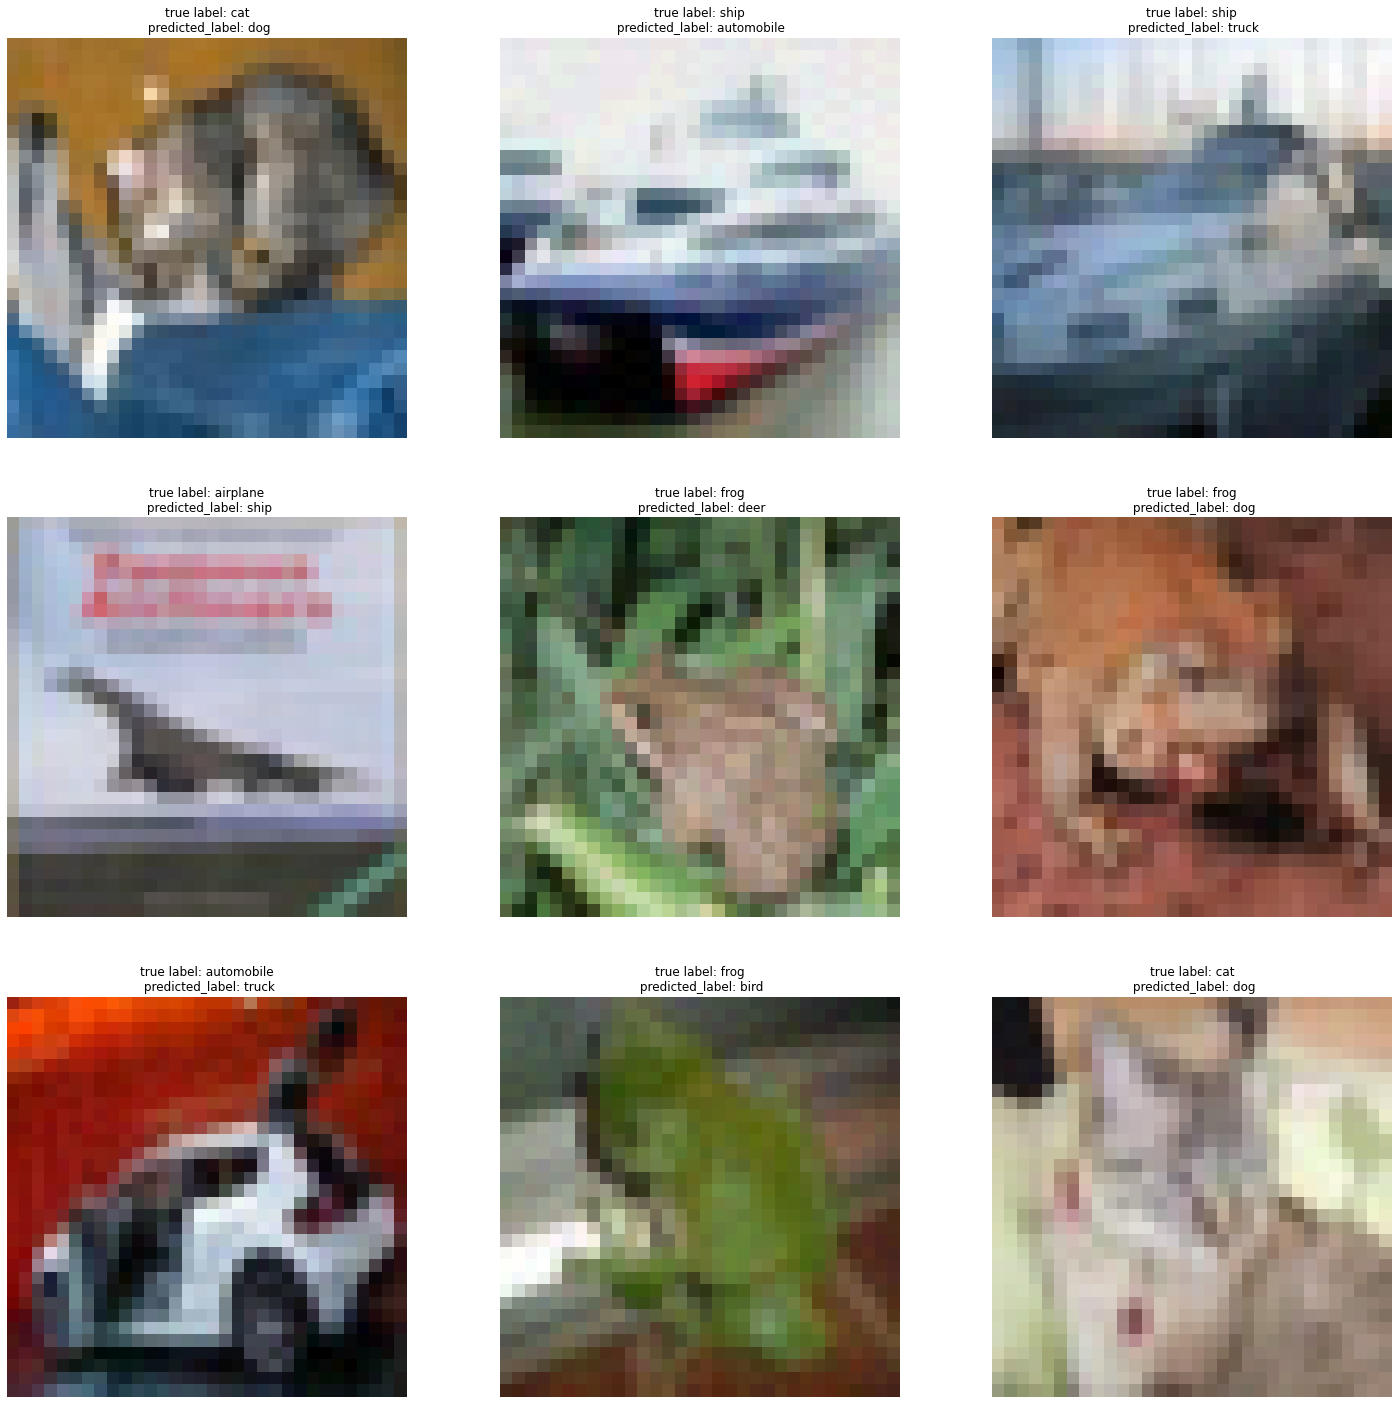

In [32]:
plt.figure(figsize=(25,25))
for i,(image, true_label) in enumerate(zip(adv_list[:9],adv_true_label[:9])): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    predicted_label=dict_classes[np.argmax(model_effnet.predict(np.expand_dims(image,axis=0)))]
    true_label=dict_classes[np.argmax(true_label)]
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label))
    plt.axis("off")

ImageNet (déjà entrainé sur le train set) va être entrainé sur les exemples adverses. A chaque époque on eregistre une version du reseau, ce qui fait qu'on obtient 15 versions du réseaux plus ou moins familières avec les exemples adverses

In [87]:
model_checkpoint_callback= ModelCheckpoint(filepath='/media/hdd1/benchmark_adversarial_attacks/weights.{epoch:d}.hdf5', 
                          monitor='val_loss', 
                          verbose=1, 
                          save_best_only=False, 
                          save_weights_only=True, 
                          mode='auto', save_freq='epoch')

history=model_effnet.fit(adv_list,
                 adv_true_label,
                 epochs=15,
                 batch_size = 64,
                 validation_split=0.1,
                 shuffle=True,
                 verbose=1,
                 callbacks=[model_checkpoint_callback])

    
    

Train on 2794 samples, validate on 311 samples
Epoch 1/15
2752/2794 [============================>.] - ETA: 0s - loss: 2.2653 - accuracy: 0.2078
Epoch 00001: saving model to /media/hdd1/benchmark_adversarial_attacks/weights.1.hdf5
2794/2794 [==============================] - 13s 5ms/sample - loss: 2.2662 - accuracy: 0.2083 - val_loss: 5.6519 - val_accuracy: 0.1447
Epoch 2/15
2752/2794 [============================>.] - ETA: 0s - loss: 2.1741 - accuracy: 0.2289
Epoch 00002: saving model to /media/hdd1/benchmark_adversarial_attacks/weights.2.hdf5
2794/2794 [==============================] - 13s 5ms/sample - loss: 2.1735 - accuracy: 0.2309 - val_loss: 3.0466 - val_accuracy: 0.1672
Epoch 3/15
2752/2794 [============================>.] - ETA: 0s - loss: 2.0829 - accuracy: 0.2420
Epoch 00003: saving model to /media/hdd1/benchmark_adversarial_attacks/weights.3.hdf5
2794/2794 [==============================] - 13s 5ms/sample - loss: 2.0864 - accuracy: 0.2412 - val_loss: 2.3708 - val_accuracy: 

#### Test des modèles

attack_performances_computer est une fonction permettant d attaquer un modèle et de revnoyer le success rate de l'attaque

In [42]:
def attack_performances_computer(model,attack, image_list, labels,epsilon):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
        prediction=model.predict(np.expand_dims(clipped[0][0],axis=0))           
        attack_value+=[np.argmax(prediction)]
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(DOC_attack,SR_attack)

In [43]:
attack_deepfool=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()

Chacune des 15 instances du modèle (plus ou moins familières avec les exemples adverses) va être attaquée. On enregistre le success rate de l'attaque sur chaque version du modèle et on plot les résutlats. On espère voir une corrélation entre le nombre d'épochs d'entrainement et le success rate de l'attaque. On procède ainsi avec deepfool et FGSM. 

In [ ]:
SR_dic={}
y_true=list(map(np.argmax,y_test))

DOC_current,SR_current=attack_performances_computer(model_effnet,attack_deepfool, X_test[5000:5100], y_true[5000:5100],[0.013])
SR_dic[0]=SR_current  
for val in tqdm(range(1,16)):       
    model_effnet.load_weights('/media/hdd1/benchmark_adversarial_attacks/weights.'+str(val)+'.hdf5')   
    DOC_current,SR_current=attack_performances_computer(model_effnet,attack_deepfool, X_test[5000:5100], y_true[5000:5100],[0.013])
    SR_dic[val]=SR_current    
    
    
    
    


 26%|██▌       | 26/100 [01:15<02:41,  2.18s/it]

In [72]:
# with open('success_extra_epoch', 'wb') as f:
#     pickle.Pickler(f).dump(SR_dic)

In [73]:
with open('success_extra_epoch', 'rb') as f:
    SR_dic=pickle.Unpickler(f).load()

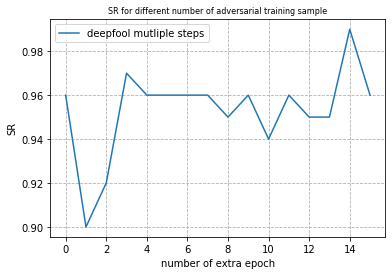

In [80]:
plt.plot(list(SR_dic.keys()),list(SR_dic.values()),label='deepfool mutliple steps')
plt.grid(True,which="both", linestyle='--')
plt.title('SR for different number of adversarial training sample', fontsize=8)
plt.xlabel('number of extra epoch')
plt.ylabel('SR')
plt.legend(loc='upper left')
plt.show()

In [50]:
attack_FGSM=LinfFastGradientAttack()

In [83]:
SR_dic_10_FGSM={}
y_true=list(map(np.argmax,y_test))

DOC_current,SR_current=attack_performances_computer(model_effnet,attack_FGSM, X_test[5000:5100], y_true[5000:5100],[0.013])
SR_dic_FGSM[0]=SR_current  
for val in tqdm(range(10,16)):       
    model_effnet.load_weights('/media/hdd1/benchmark_adversarial_attacks/weights.'+str(val)+'.hdf5')   
    DOC_current,SR_current=attack_performances_computer(model_effnet,attack_FGSM, X_test[5000:5100], y_true[5000:5100],[0.013])
    SR_dic_10_FGSM[val]=SR_current    
    
    

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

100%|██████████| 6/6 [09:18<00:00, 93.07s/it]


In [84]:
SR_dic_FGSM.update(SR_dic_10_FGSM)

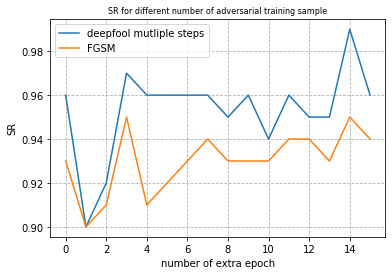

In [85]:
plt.plot(list(SR_dic.keys()),list(SR_dic.values()),label='deepfool mutliple steps')
plt.plot(list(SR_dic_FGSM.keys()),list(SR_dic_FGSM.values()),label='FGSM')
plt.grid(True,which="both", linestyle='--')
plt.title('SR for different number of adversarial training sample', fontsize=8)
plt.xlabel('number of extra epoch')
plt.ylabel('SR')
plt.legend(loc='upper left')
plt.show()